<a href="https://colab.research.google.com/github/JeelDhamsaniya/CVDL-practicals/blob/main/CVDL5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

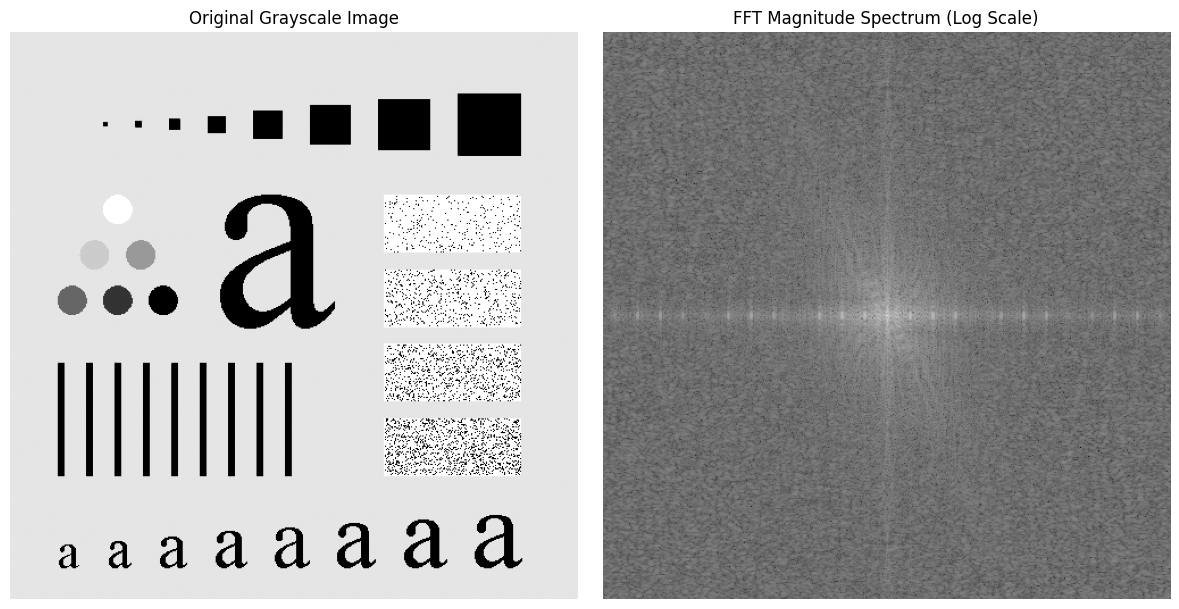

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

image_url = "/content/sample_data/abcl.jpg"

original_image = Image.open(image_url)
grayscale_array = np.array(original_image.convert('L'))

frequency_domain = np.fft.fft2(grayscale_array)

centered_fft = np.fft.fftshift(frequency_domain)

log_magnitude = 20 * np.log(np.abs(centered_fft))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(grayscale_array, cmap='gray')
plt.title('Original Grayscale Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(log_magnitude, cmap='gray')
plt.title('FFT Magnitude Spectrum (Log Scale)')
plt.axis('off')

plt.tight_layout()
plt.show()

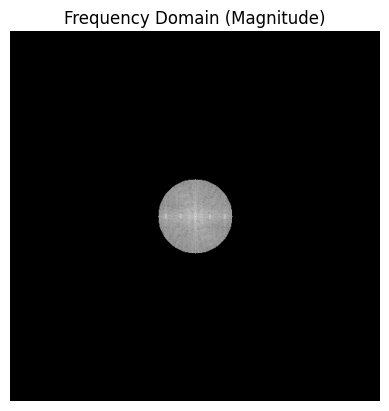

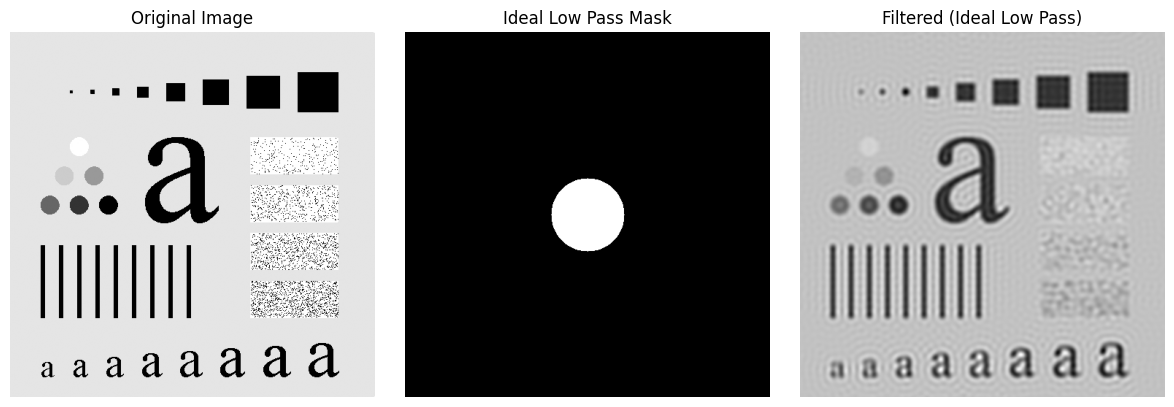

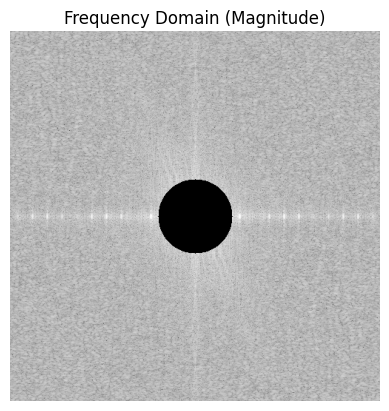

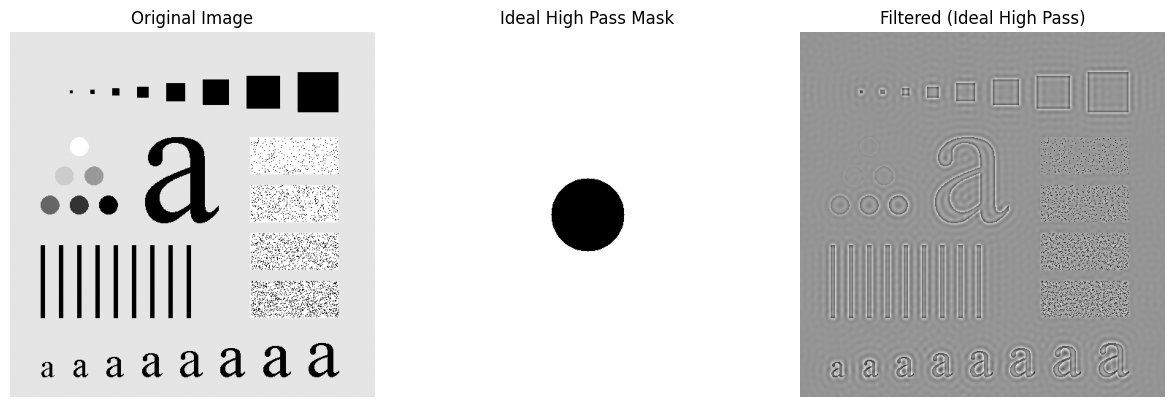

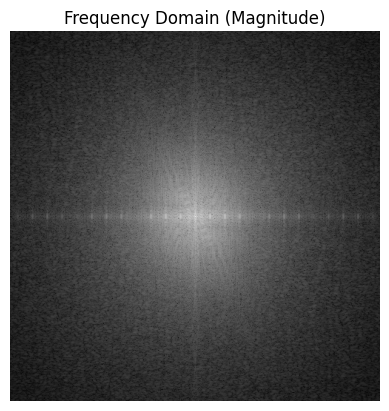

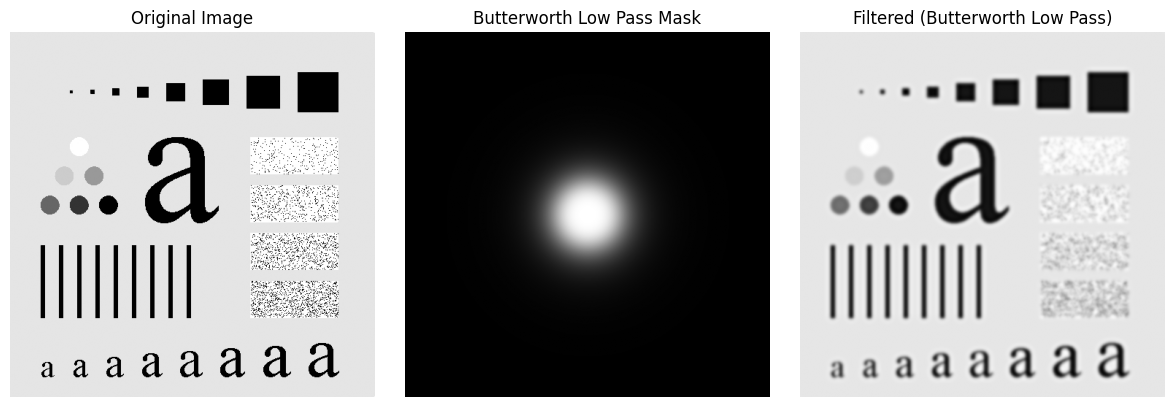

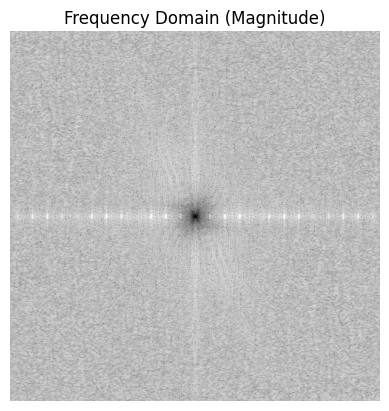

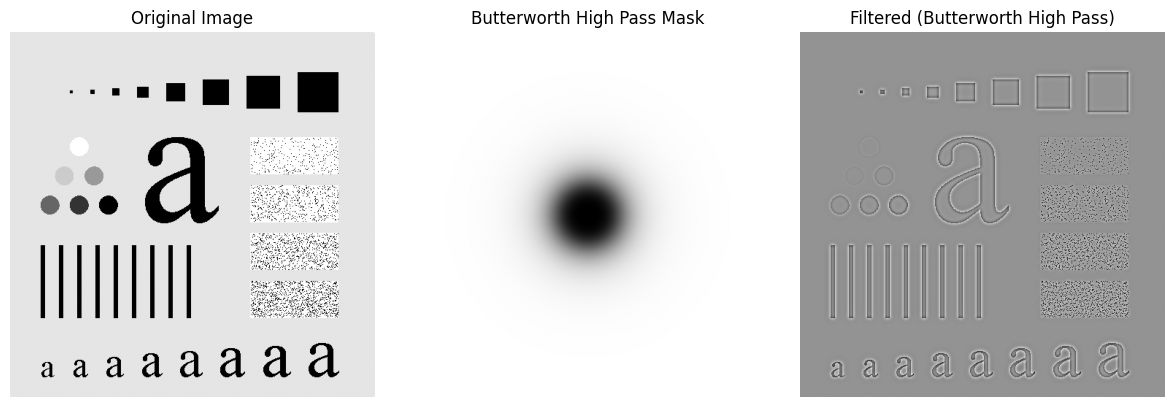

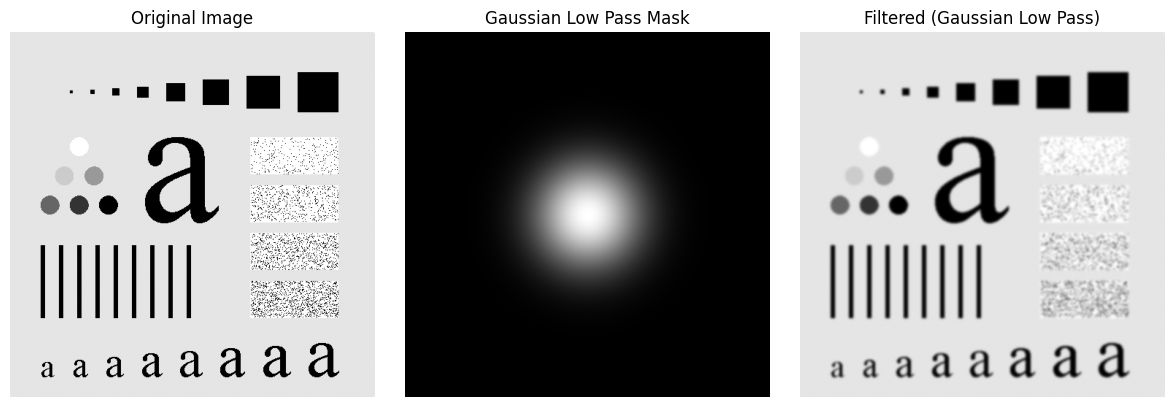

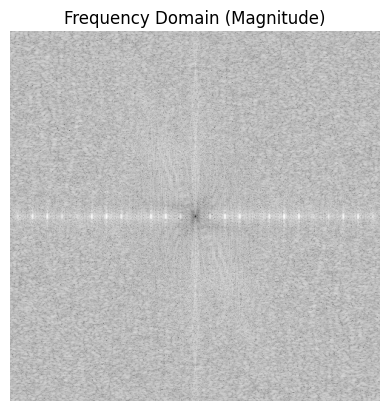

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def create_shift_mask(img):
    rows, cols = img.shape
    mask = np.ones((rows, cols), dtype=np.float32)
    for i in range(rows):
        for j in range(cols):
            if (i + j) % 2 == 1:
                mask[i, j] = -1
    return mask


def plot_filter_result(img, mask, img_back, filter_name):
    plt.figure(figsize=(12, 4))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Mask
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title(f'{filter_name} Mask')
    plt.axis('off')

    # Filtered image
    plt.subplot(1, 3, 3)
    plt.imshow(img_back, cmap='gray')
    plt.title(f'Filtered ({filter_name})')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


def apply_filter(img, mask, filter_name):
    shift_mask = create_shift_mask(img)
    shifted_img = img * shift_mask

    fft = cv2.dft(np.float32(shifted_img), flags=cv2.DFT_COMPLEX_OUTPUT)

    mask_3d = np.repeat(mask[:, :, np.newaxis], 2, axis=2)

    fft_filtered = fft * mask_3d
    # magnitude_spectrum = cv2.magnitude(fft_filtered[:, :, 0], fft_filtered[:, :, 1])
    # magnitude_spectrum = 20 * np.log(magnitude_spectrum + 1)

    # plt.imshow(magnitude_spectrum, cmap="gray")
    # plt.title("Frequency Domain (Magnitude)")
    # plt.axis('off')
    # plt.show()
    img_back = cv2.idft(fft_filtered, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT)
    img_back = img_back * shift_mask

    return img_back

def apply_ideal_low_pass(img, cutoff):
    rows, cols = img.shape
    center_row, center_col = rows // 2, cols // 2
    mask = np.zeros((rows, cols), dtype=np.float32)
    for i in range(rows):
        for j in range(cols):
            if np.sqrt((i - center_row)**2 + (j - center_col)**2) <= cutoff:
                mask[i, j] = 1
    img_back = apply_filter(img, mask, "Ideal Low Pass")
    plot_filter_result(img, mask, img_back, "Ideal Low Pass")


def apply_ideal_high_pass(img, cutoff):
    rows, cols = img.shape
    center_row, center_col = rows // 2, cols // 2
    mask = np.ones((rows, cols), dtype=np.float32)
    for i in range(rows):
        for j in range(cols):
            if np.sqrt((i - center_row)**2 + (j - center_col)**2) <= cutoff:
                mask[i, j] = 0
    img_back = apply_filter(img, mask, "Ideal High Pass")
    plot_filter_result(img, mask, img_back, "Ideal High Pass")


def apply_butterworth_low_pass(img, cutoff, order):
    rows, cols = img.shape
    center_row, center_col = rows // 2, cols // 2
    mask = np.zeros((rows, cols), dtype=np.float32)
    for i in range(rows):
        for j in range(cols):
            d = np.sqrt((i - center_row)**2 + (j - center_col)**2)
            mask[i, j] = 1 / (1 + (d / cutoff)**(2 * order))
    img_back = apply_filter(img, mask, "Butterworth Low Pass")
    plot_filter_result(img, mask, img_back, "Butterworth Low Pass")


def apply_butterworth_high_pass(img, cutoff, order):
    rows, cols = img.shape
    center_row, center_col = rows // 2, cols // 2
    mask = np.zeros((rows, cols), dtype=np.float32)
    for i in range(rows):
        for j in range(cols):
            d = np.sqrt((i - center_row)**2 + (j - center_col)**2)
            if d != 0:
                mask[i, j] = 1 / (1 + (cutoff / d)**(2 * order))
    img_back = apply_filter(img, mask, "Butterworth High Pass")
    plot_filter_result(img, mask, img_back, "Butterworth High Pass")


def apply_gaussian_low_pass(img, cutoff):
    rows, cols = img.shape
    center_row, center_col = rows // 2, cols // 2
    mask = np.zeros((rows, cols), dtype=np.float32)
    for i in range(rows):
        for j in range(cols):
            d = np.sqrt((i - center_row)**2 + (j - center_col)**2)
            mask[i, j] = np.exp(-(d**2) / (2 * (cutoff**2)))
    img_back = apply_filter(img, mask, "Gaussian Low Pass")
    plot_filter_result(img, mask, img_back, "Gaussian Low Pass")


def apply_gaussian_high_pass(img, cutoff):
    rows, cols = img.shape
    center_row, center_col = rows // 2, cols // 2
    mask = np.zeros((rows, cols), dtype=np.float32)
    for i in range(rows):
        for j in range(cols):
            d = np.sqrt((i - center_row)**2 + (j - center_col)**2)
            mask[i, j] = 1 - np.exp(-(d**2) / (2 * (cutoff**2)))
    img_back = apply_filter(img, mask, "Gaussian High Pass")
    plot_filter_result(img, mask, img_back, "Gaussian High Pass")

def apply_ideal_notch_filter(img, centers, cutoff):
    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.ones((rows, cols), np.float32)

    for (u, v) in centers:
        for i in range(rows):
            for j in range(cols):
                d1 = np.sqrt((i - (crow + u))**2 + (j - (ccol + v))**2)
                d2 = np.sqrt((i - (crow - u))**2 + (j - (ccol - v))**2)
                if d1 <= cutoff or d2 <= cutoff:
                    mask[i, j] = 0

    img_back = apply_filter(img, mask, "Ideal Notch Reject")
    plot_filter_result(img, mask, img_back, "Ideal Notch Reject")


def apply_butterworth_notch_filter(img, centers, cutoff, order=2):
    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.ones((rows, cols), np.float32)

    for (u, v) in centers:
        for i in range(rows):
            for j in range(cols):
                d1 = np.sqrt((i - (crow + u))**2 + (j - (ccol + v))**2)
                d2 = np.sqrt((i - (crow - u))**2 + (j - (ccol - v))**2)
                H = 1 / (1 + (cutoff**2 / (d1 * d2 + 1e-6))**order)
                mask[i, j] *= H

    img_back = apply_filter(img, mask, "Butterworth Notch Reject")
    plot_filter_result(img, mask, img_back, "Butterworth Notch Reject")


def apply_gaussian_notch_filter(img, centers, cutoff):
    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.ones((rows, cols), np.float32)

    for (u, v) in centers:
        for i in range(rows):
            for j in range(cols):
                d1 = np.sqrt((i - (crow + u))**2 + (j - (ccol + v))**2)
                d2 = np.sqrt((i - (crow - u))**2 + (j - (ccol - v))**2)
                H = 1 - np.exp(-0.5 * ((cutoff**2) / (d1 * d2 + 1e-6)))
                mask[i, j] *= H

    img_back = apply_filter(img, mask, "Gaussian Notch Reject")
    plot_filter_result(img, mask, img_back, "Gaussian Notch Reject")

img = cv2.imread("/content/sample_data/abcl.jpg", cv2.IMREAD_GRAYSCALE)

apply_ideal_low_pass(img, 50)
apply_ideal_high_pass(img, 50)
apply_butterworth_low_pass(img, 50, 2)
apply_butterworth_high_pass(img, 50, 2)
apply_gaussian_low_pass(img, 50)
apply_gaussian_high_pass(img, 50)





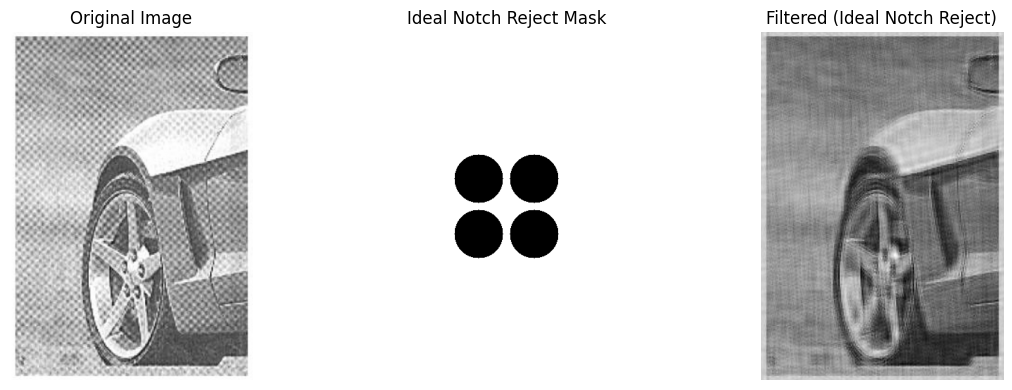

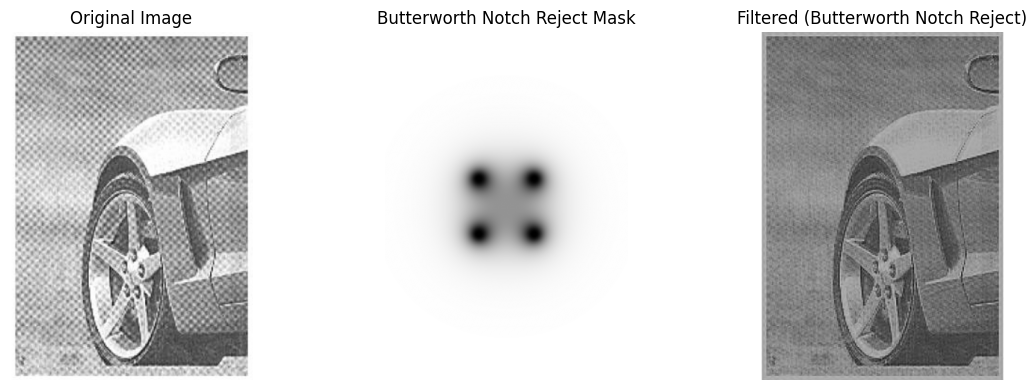

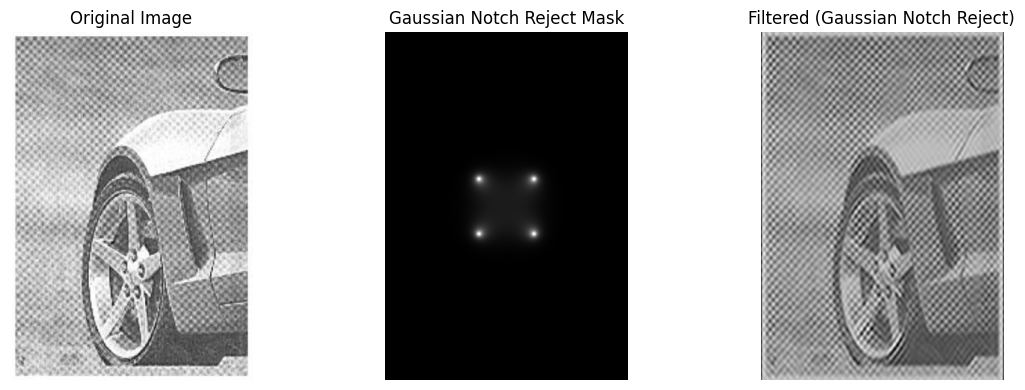

In [ ]:
img = cv2.imread("/content/sample_data/car.png", cv2.IMREAD_GRAYSCALE)



apply_ideal_notch_filter(img, [(40, 40), (-40, 40), (40, -40), (-40, -40)], 35)
apply_butterworth_notch_filter(img, [(40, 40), (-40, 40), (40, -40), (-40, -40)], 35)
apply_gaussian_notch_filter(img, [(40, 40), (-40, 40), (40, -40), (-40, -40)], 35)

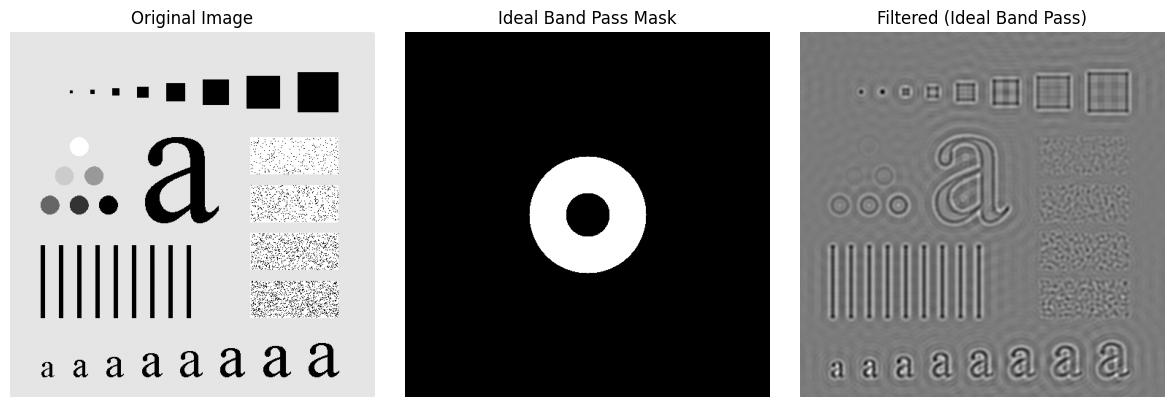

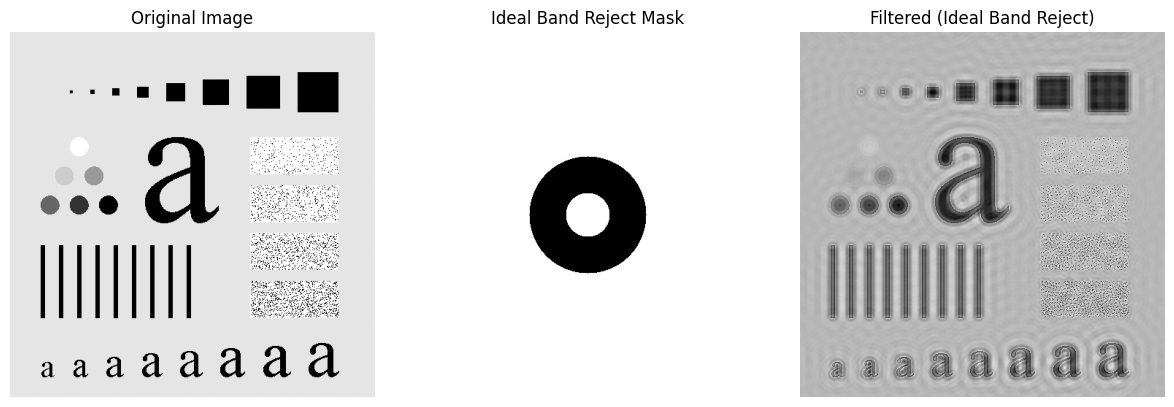

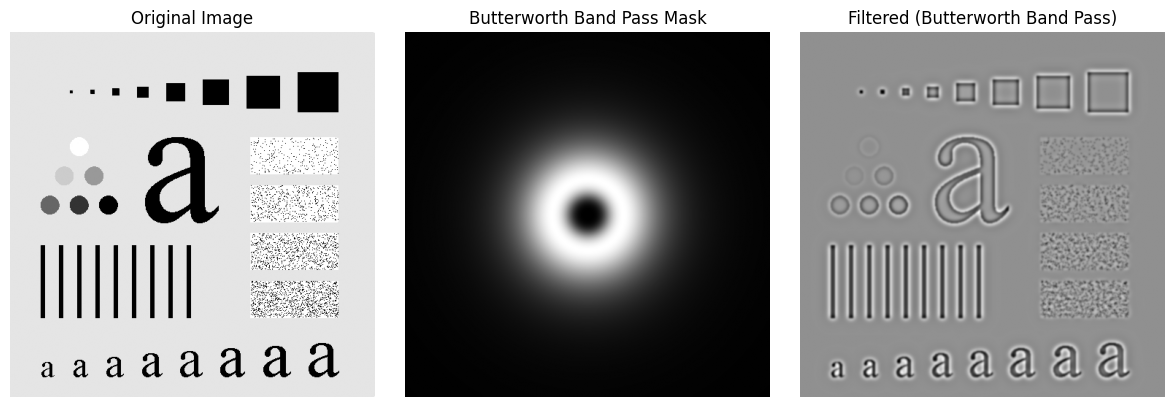

In [ ]:
def apply_ideal_band_pass(img, low_cutoff, high_cutoff):
    rows, cols = img.shape
    center_row, center_col = rows // 2, cols // 2
    mask = np.zeros((rows, cols), dtype=np.float32)
    for i in range(rows):
        for j in range(cols):
            d = np.sqrt((i - center_row)**2 + (j - center_col)**2)
            if low_cutoff <= d <= high_cutoff:
                mask[i, j] = 1
    img_back = apply_filter(img, mask, "Ideal Band Pass")
    plot_filter_result(img, mask, img_back, "Ideal Band Pass")


def apply_ideal_band_reject(img, low_cutoff, high_cutoff):
    rows, cols = img.shape
    center_row, center_col = rows // 2, cols // 2
    mask = np.ones((rows, cols), dtype=np.float32)
    for i in range(rows):
        for j in range(cols):
            d = np.sqrt((i - center_row)**2 + (j - center_col)**2)
            if low_cutoff <= d <= high_cutoff:
                mask[i, j] = 0
    img_back = apply_filter(img, mask, "Ideal Band Reject")
    plot_filter_result(img, mask, img_back, "Ideal Band Reject")


def apply_butterworth_band_pass(img, low_cutoff, high_cutoff, order=2):
    rows, cols = img.shape
    center_row, center_col = rows // 2, cols // 2
    mask = np.zeros((rows, cols), dtype=np.float32)
    for i in range(rows):
        for j in range(cols):
            d = np.sqrt((i - center_row)**2 + (j - center_col)**2)
            if d != 0:
                mask[i, j] = 1 / (1 + (low_cutoff / d)**(2*order)) * (1 / (1 + (d / high_cutoff)**(2*order)))
    img_back = apply_filter(img, mask, "Butterworth Band Pass")
    plot_filter_result(img, mask, img_back, "Butterworth Band Pass")


def apply_butterworth_band_reject(img, low_cutoff, high_cutoff, order=2):
    rows, cols = img.shape
    center_row, center_col = rows // 2, cols // 2
    mask = np.ones((rows, cols), dtype=np.float32)
    for i in range(rows):
        for j in range(cols):
            d = np.sqrt((i - center_row)**2 + (j - center_col)**2)
            if d != 0:
                mask[i, j] = 1 - (1 / (1 + (low_cutoff / d)**(2*order)) * (1 / (1 + (d / high_cutoff)**(2*order))))
    img_back = apply_filter(img, mask, "Butterworth Band Reject")
    plot_filter_result(img, mask, img_back, "Butterworth Band Reject")

low_cutoff = 30
high_cutoff = 80
order = 2

apply_ideal_band_pass(img, low_cutoff, high_cutoff)
apply_ideal_band_reject(img, low_cutoff, high_cutoff)

apply_butterworth_band_pass(img, low_cutoff, high_cutoff, order)
apply_butterworth_band_reject(img, low_cutoff, high_cutoff, order)